In [1]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from backtest_functions_v2 import *

In [2]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v1.parquet")

In [3]:
print(df.shape)

(35058, 141)


In [4]:
columns = df.columns.tolist()
for i in range(0, len(columns), 5):
  print(columns[i:i+5])

['news_count', 'return_forward', 'sma_5_20_diff', 'sma_20_50_diff', 'sma_50_200_diff']
['ema_5_20_diff', 'ema_20_50_diff', 'ema_50_200_diff', 'sma_5_20_diff_abs_chg', 'sma_5_20_diff_pct_chg']
['sma_20_50_diff_abs_chg', 'sma_20_50_diff_pct_chg', 'sma_50_200_diff_abs_chg', 'sma_50_200_diff_pct_chg', 'ema_5_20_diff_abs_chg']
['ema_5_20_diff_pct_chg', 'ema_20_50_diff_abs_chg', 'ema_20_50_diff_pct_chg', 'ema_50_200_diff_abs_chg', 'ema_50_200_diff_pct_chg']
['macd_12_26', 'signal_line_9', 'macd_histogram', 'macd_position', 'macd_crossover']
['adx', '+di', '-di', 'adx_slope', 'adx_strength']
['di_crossover', 'di_spread', 'adx_di_composite', 'rsi_7', 'rsi_14']
['rsi_7_slope', 'rsi_7_chg', 'rsi_7_acceleration', 'rsi_14_slope', 'rsi_14_chg']
['rsi_14_acceleration', 'rsi_ratio', 'atr_7', 'atr_14', 'atr_7_slope']
['atr_7_chg', 'atr_14_slope', 'atr_14_chg', 'norm_price_change_7', 'norm_price_change_14']
['atr_ratio', 'trailing_stop_long_7', 'trailing_stop_long_14', 'trailing_stop_short_7', 'trailin

### Spliting dataset

In [5]:
# list of features column names
all_features = df.columns.drop(['target', 'return_forward'])

In [6]:
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[all_features]
y_train = df_train['target']
X_test = df_test[all_features]
y_test = df_test['target']

# Print class distribution
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### Model (logistic regression)

In [7]:
# Time Series Cross-Validation for RFECV and potential outer loop if needed
tscv = TimeSeriesSplit(n_splits=5)

# Define the base Logistic Regression model
lr_model = LogisticRegression(
    penalty='l1',         # L1 regularization
    solver='saga',       # Optimizer for L1
    max_iter=10000,       # Ensure convergence
    random_state=42,
    class_weight='balanced', # Handle class imbalance
    C=1                 # Regularization strength
)

# Setup RFECV
rfecv = RFECV(
    estimator=lr_model,
    step=3,                # Remove 3 feature at a time
    cv=tscv,               # Use time series cross-validation
    scoring='roc_auc_ovr', # Scoring metric for multi-class
    min_features_to_select=20, # Minimum number of features
    n_jobs=-1,
    verbose=1
)

# Create the pipeline with scaling and RFECV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', rfecv)
    # The final estimator (lr_model) is part of RFECV
])

# Fit the pipeline
print("Starting RFECV fitting...")
pipeline.fit(X_train, y_train)
print("RFECV fitting complete.")

# The best estimator is now the fitted pipeline itself
best_model = pipeline

# RFECV automatically refits the estimator on the full training data with the selected features
print(f"Optimal number of features selected by RFECV: {best_model.named_steps['feature_selection'].n_features_}")

Starting RFECV fitting...
Fitting estimator with 139 features.
Fitting estimator with 139 features.
Fitting estimator with 139 features.
Fitting estimator with 139 features.
Fitting estimator with 139 features.
Fitting estimator with 136 features.
Fitting estimator with 136 features.
Fitting estimator with 133 features.
Fitting estimator with 130 features.
Fitting estimator with 127 features.
Fitting estimator with 133 features.
Fitting estimator with 124 features.
Fitting estimator with 136 features.
Fitting estimator with 121 features.
Fitting estimator with 130 features.
Fitting estimator with 136 features.
Fitting estimator with 118 features.
Fitting estimator with 115 features.
Fitting estimator with 127 features.
Fitting estimator with 136 features.
Fitting estimator with 112 features.
Fitting estimator with 109 features.
Fitting estimator with 124 features.
Fitting estimator with 106 features.
Fitting estimator with 103 features.
Fitting estimator with 100 features.
Fitting esti

In [8]:
# Evaluate on test set using the fitted pipeline
y_pred = best_model.predict(X_test)
y_proba_full = best_model.predict_proba(X_test)

In [9]:
# Performance metrics
# print(f"Best Parameters: {grid_search.best_params_}") # No grid search used
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Get the full probability matrix for multi-class ROC AUC
# y_proba_full = best_model.predict_proba(X_test) # Already calculated
print(f"Test ROC AUC (OvR): {roc_auc_score(y_test, y_proba_full, multi_class='ovr'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.4888
Test ROC AUC (OvR): 0.6964

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.36      0.38      2648
           1       0.53      0.75      0.62      3274
           2       0.47      0.31      0.38      2862

    accuracy                           0.49      8784
   macro avg       0.47      0.47      0.46      8784
weighted avg       0.48      0.49      0.47      8784



Shape of coefficient matrix (selected features): (3, 25)
Number of selected features: 25

Top 15 most important features for Bearish (0) (among selected):
                  Feature  Coefficient  Abs_Coefficient
23          lower_band_20     2.678142         2.678142
22          upper_band_20    -1.336726         1.336726
20  trailing_stop_long_14    -1.071225         1.071225
19   trailing_stop_long_7    -0.958239         0.958239
21          lower_band_10     0.548332         0.548332
5                   rsi_7     0.438885         0.438885
6                  rsi_14    -0.435759         0.435759
24          20_band_width     0.082312         0.082312
14              atr_7_chg     0.040562         0.040562
16             atr_14_chg    -0.021120         0.021120
17   norm_price_change_14     0.005051         0.005051
18              atr_ratio     0.000000         0.000000
15           atr_14_slope     0.000000         0.000000
0           sma_5_20_diff     0.000000         0.000000
13   

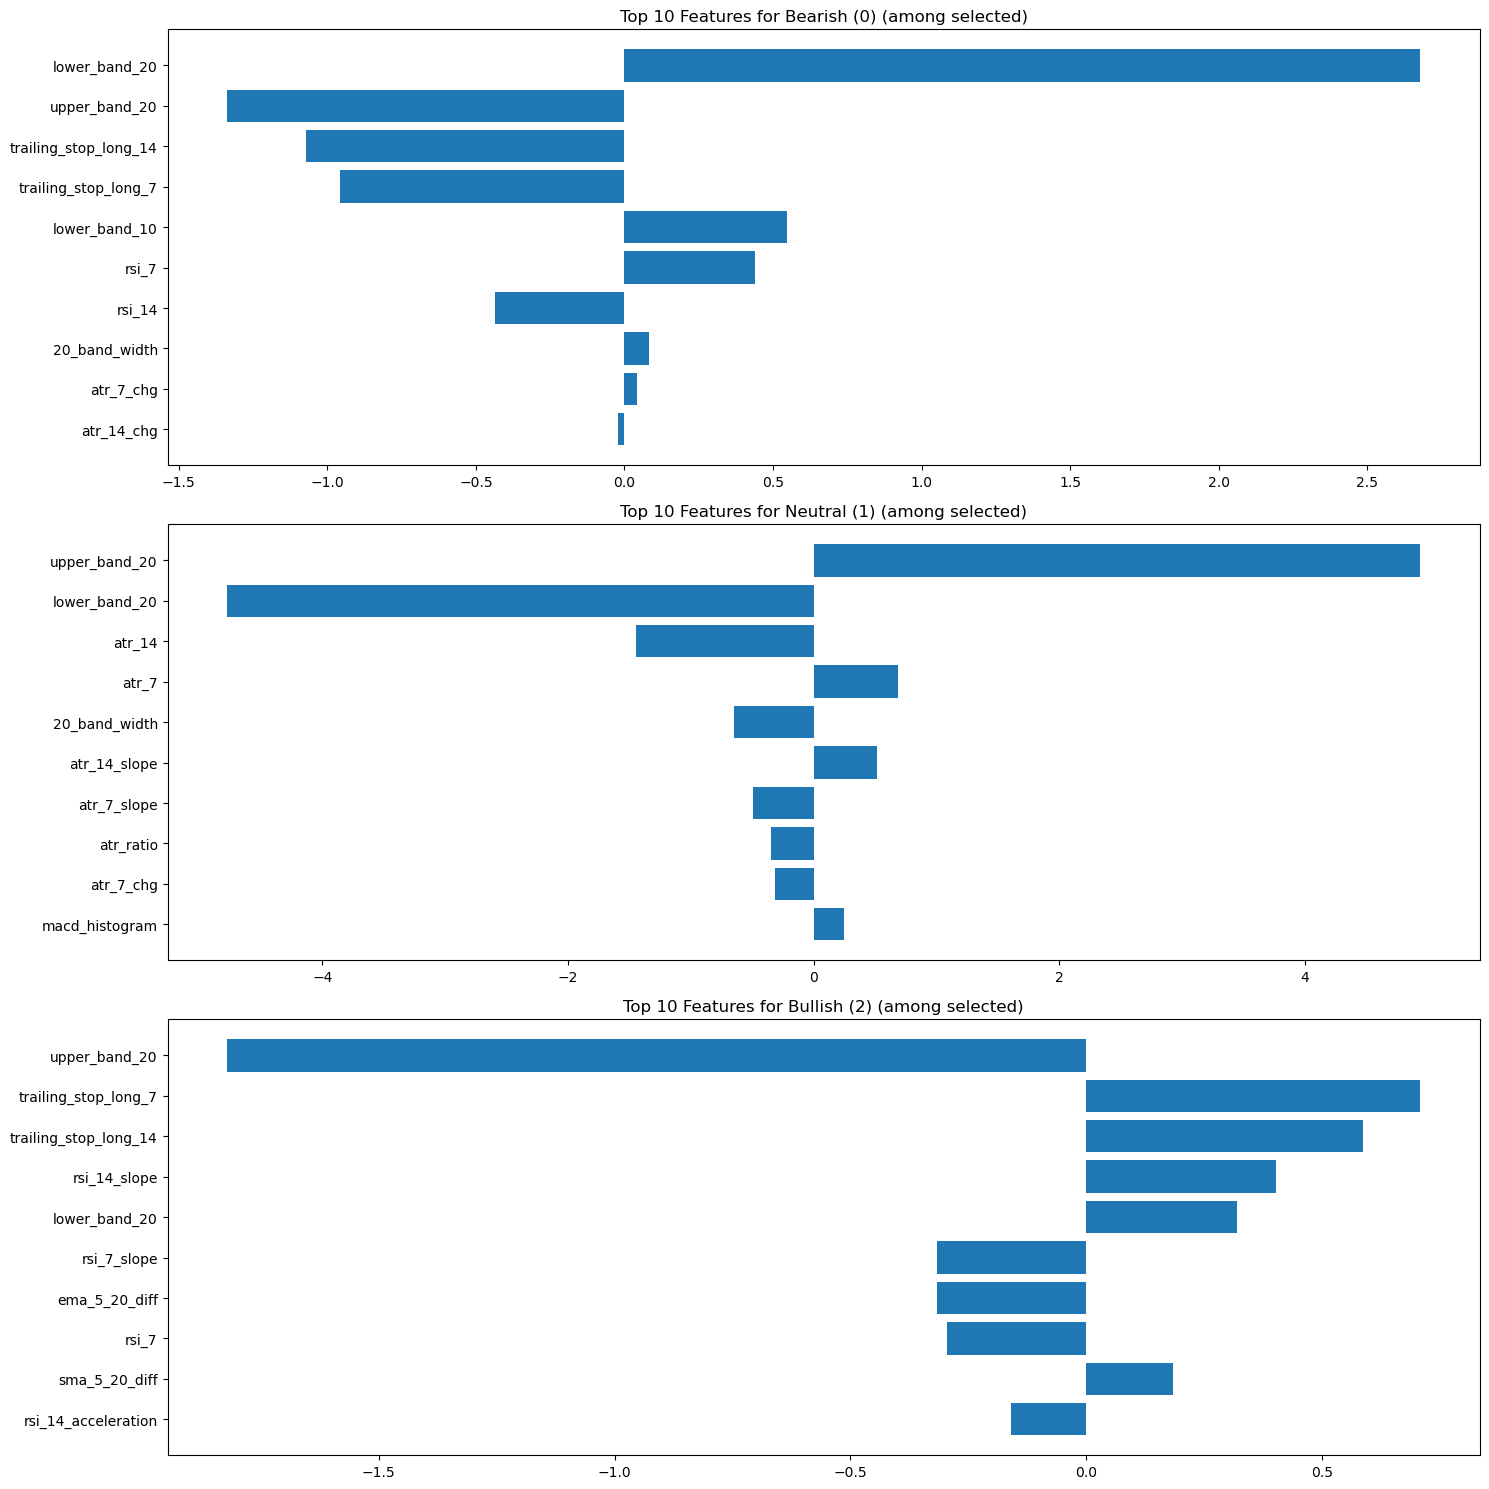


Number of features selected by RFECV: 25
Number of non-zero coefficients after L1 (within selected): 48
Total number of original features: 139


In [10]:
# Get the final fitted Logistic Regression model from RFECV
final_estimator = best_model.named_steps['feature_selection'].estimator_
coefficients = final_estimator.coef_

# Get the boolean mask of selected features from RFECV
feature_mask = best_model.named_steps['feature_selection'].support_

# Get the names of the selected features
all_feature_names = X_train.columns
selected_feature_names = all_feature_names[feature_mask]

# Print the shape of coefficients to understand the structure
print(f"Shape of coefficient matrix (selected features): {coefficients.shape}")
print(f"Number of selected features: {len(selected_feature_names)}")

# Create a function to display coefficients for a class
def display_class_coefficients(class_idx, class_name):
  # For multi-class, coefficients has shape (n_classes, n_selected_features)
  class_coefs = coefficients[class_idx]
  
  # Create a DataFrame using selected feature names
  coef_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': class_coefs
  })
  
  # Sort by absolute coefficient value
  coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
  coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
  
  # Display top features
  print(f"\nTop 15 most important features for {class_name} (among selected):")
  print(coef_df.head(15))
  
  return coef_df

# Display coefficients for each class
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)']

plt.figure(figsize=(15, 15))

for i, class_name in enumerate(class_names):
  coef_df = display_class_coefficients(i, class_name)
  
  # Plot top 10
  top_10_df = coef_df.head(10)
  plt.subplot(3, 1, i+1)
  plt.barh(top_10_df['Feature'], top_10_df['Coefficient'])
  plt.title(f'Top 10 Features for {class_name} (among selected)')
  plt.gca().invert_yaxis() # Display most important at top

plt.tight_layout()
plt.show()

# Count number of non-zero coefficients (already selected by RFECV, L1 might zero out more)
non_zero_coef = (np.abs(coefficients) > 1e-5).sum()
print(f"\nNumber of features selected by RFECV: {len(selected_feature_names)}")
print(f"Number of non-zero coefficients after L1 (within selected): {non_zero_coef}")
print(f"Total number of original features: {len(all_feature_names)}")

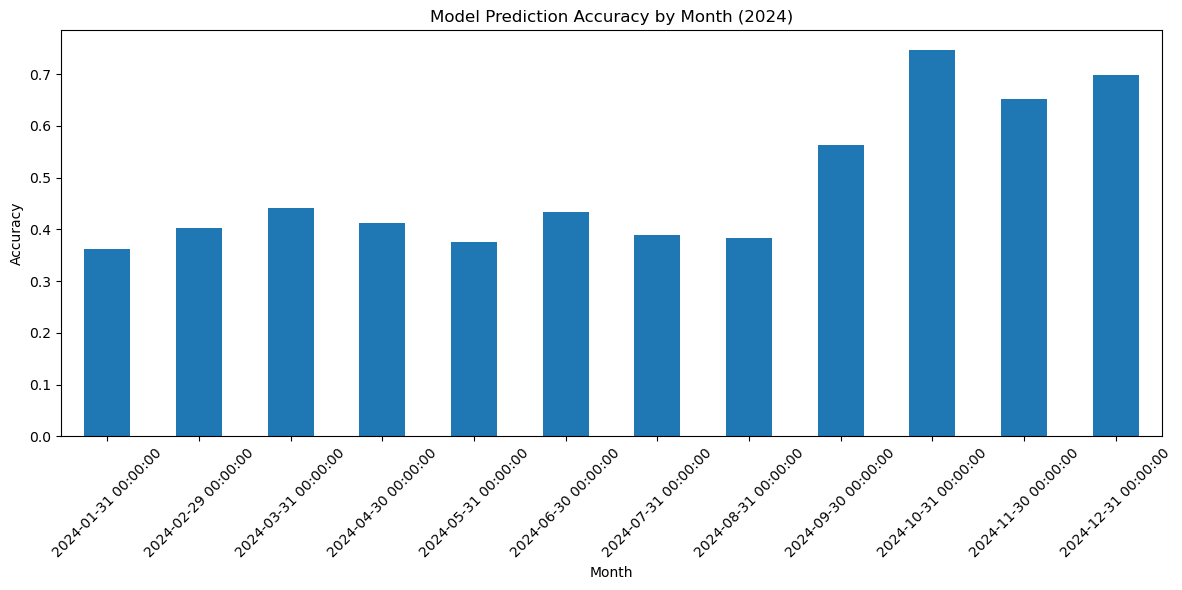

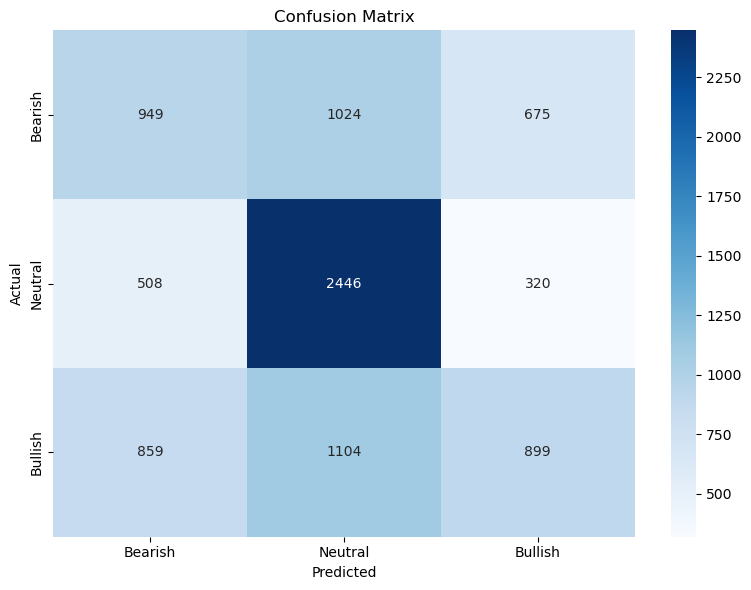

In [11]:
# Add predictions and probabilities to test dataframe
df_test_copy = df_test.copy() # Avoid SettingWithCopyWarning
df_test_copy.loc[:, 'predicted_class'] = y_pred
df_test_copy.loc[:, 'prob_bearish'] = y_proba_full[:, 0]
df_test_copy.loc[:, 'prob_neutral'] = y_proba_full[:, 1]
df_test_copy.loc[:, 'prob_bullish'] = y_proba_full[:, 2]

# Map target values to more descriptive labels
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}
df_test_copy.loc[:, 'actual_label'] = df_test_copy['target'].map(target_map)
df_test_copy.loc[:, 'predicted_label'] = df_test_copy['predicted_class'].map(target_map)

# Calculate whether the prediction was correct
df_test_copy.loc[:, 'correct_prediction'] = (df_test_copy['target'] == df_test_copy['predicted_class']).astype(int)

# Calculate monthly accuracy
monthly_accuracy = df_test_copy.resample('ME')['correct_prediction'].mean()

# Plot monthly accuracy
plt.figure(figsize=(12, 6))
monthly_accuracy.plot(kind='bar')
plt.title('Model Prediction Accuracy by Month (2024)')
plt.ylabel('Accuracy')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show confusion matrix
conf_matrix = confusion_matrix(df_test_copy['target'], df_test_copy['predicted_class'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
      xticklabels=['Bearish', 'Neutral', 'Bullish'],
      yticklabels=['Bearish', 'Neutral', 'Bullish'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Assign back if needed, or use df_test_copy going forward
df_test = df_test_copy

### Backtest

In [12]:
df_test.head()

,news_count,return_forward,sma_5_20_diff,sma_20_50_diff,sma_50_200_diff,ema_5_20_diff,ema_20_50_diff,ema_50_200_diff,sma_5_20_diff_abs_chg,sma_5_20_diff_pct_chg,...,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h,predicted_class,prob_bearish,prob_neutral,prob_bullish,actual_label,predicted_label,correct_prediction
2024-01-01 00:00:00,0.0,-0.001385,143.55,210.51,-647.125,123.182375,73.241757,-290.164294,-3.40,-0.023137,...,0.097778,0.003539,0.010173,1,0.289110,0.457244,0.253646,Bearish,Neutral,0
2024-01-01 01:00:00,1.0,-0.000729,151.35,210.81,-631.665,101.159360,74.849008,-282.793610,7.80,0.054336,...,0.089956,0.002359,0.009359,1,0.266121,0.444889,0.288991,Neutral,Neutral,1
2024-01-01 02:00:00,3.0,-0.005929,120.60,219.66,-617.505,77.283277,74.229918,-276.579317,-30.75,-0.203171,...,0.135111,0.028840,0.015154,1,0.252512,0.440204,0.307284,Bearish,Neutral,0
2024-01-01 03:00:00,4.0,0.000095,43.45,223.39,-605.320,0.428392,59.296872,-277.935098,-77.15,-0.639718,...,0.124302,0.019226,0.013942,2,0.263151,0.302970,0.433879,Neutral,Bullish,0
2024-01-01 04:00:00,2.0,0.005017,-37.10,221.12,-591.100,-44.989742,46.318484,-278.999237,-80.55,-1.853855,...,0.114358,0.012818,0.012827,2,0.249988,0.346331,0.403681,Bullish,Bullish,1


Overall Annual Return: 5.05%
Overall Annual Sharpe Ratio: 0.3294
Maximum Drawdown: -32.48 %
Alpha: 0.1128
Beta: 0.0366

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.050466     0.42797     0.036633      0.106888       0.329437


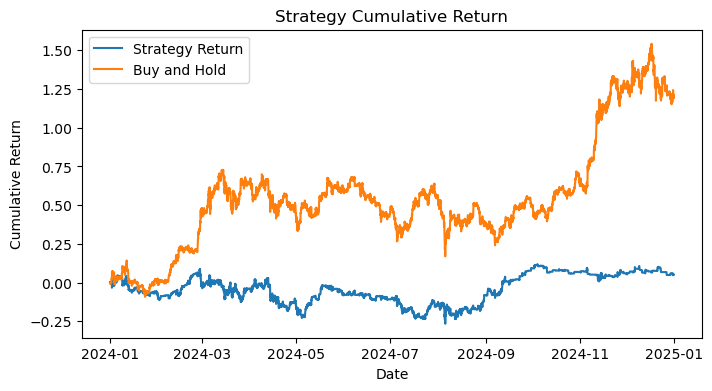

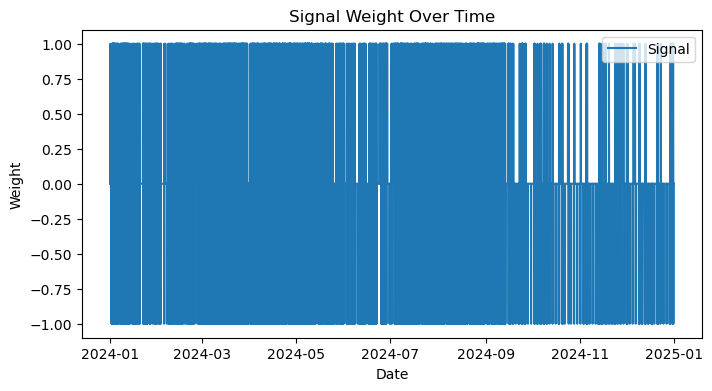

In [13]:
df_test['signal'] = df_test['predicted_class'] - 1
run_backtest(df_test, freq='h')